In [9]:
import spacy
import timeit
import math
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from collections import Counter
from lxml import etree
from glob import glob
from unicodedata import normalize

In [2]:
%matplotlib inline

In [3]:
nlp = spacy.load('fr_core_news_md')

In [4]:
def est_canon(tree):
    if tree.find(".//profileDesc") is not None:
        profil = tree.find(".//profileDesc")
        if profil.get("tag") == "canon":
            return True
        else:
            return False

In [5]:
def lemmatize(path):
    list_lemma = []
    with open(path, encoding="utf8") as file:
        tree = etree.parse(file)
        tag = est_canon(tree)
        if tag == True:
            print("canon")
        else:
            print("non_canon")
        if tree.findall(".//p"):
            for paragraphe in tree.findall(".//p"):
                if paragraphe.text:
                    clean_text = normalize("NFKD", paragraphe.text)
                    docs = nlp(clean_text)
                    for token in docs:
                        if token.pos_ != "PUNCT" and "SPACE" and "X" and "SYM":
                            list_lemma.append(token.lemma_)
    return list_lemma, tag

In [6]:
def bigrammize(list_lemma):
    list_bigram = []
    for indice_lemma in range(len(list_lemma)-1):
        bigram = list_lemma[indice_lemma]+'_'+list_lemma[indice_lemma+1]
        list_bigram.append(bigram)
    return list_bigram

In [7]:
def rollingnwords(list_lemma, n):
    i = 0 # i stocke l'indice auquel on est dans le rolling
    list_rolling = []
    while i-n < len(list_lemma):
        list_rolling.append(list_lemma[i:i+n])
        i+=n
    return list_rolling    

In [8]:
def rolling_type_token(rolling_list_lemma, window):
    list_rolling_type_token = []
    for list_lemma in rolling_list_lemma:
        lemmes_freq = Counter()
        for lemma in list_lemma:
            lemmes_freq[lemma] += 1
        if sum(lemmes_freq.values()) == window:
            list_rolling_type_token.append(round(len(lemmes_freq)/sum(lemmes_freq.values()),2))                                      
    return list_rolling_type_token

In [10]:
# Cette fonction mesure shannon sur les 100 bigrammes les plus communs de chaque roman
def shannon_diversity(list_bigram, nombre_bigrammes):
    # initialisation de l'indice de shannon
    shannon_sum = 0
    dict_conteur = dict(Counter(list_bigram).most_common(nombre_bigrammes))
    # on recupere la proportion pi de chaque bigram par rapport à tous les autres bigrams
    for bigram in list_bigram:
        if bigram in dict_conteur.keys():
            prop = dict_conteur[bigram]/len(list_bigram)
            # on met à jour l'indice de shannon
            shannon_courant = prop * (math.log(prop, 2))
            shannon_sum += shannon_courant
    return round(shannon_sum * -1,2)

In [11]:
def rolling_shannon(rolling_list_bigram, nombre_bigrammes):
    shannon_measures = []
    for list_bigram in rolling_list_bigram:     
        shannon_measures.append(shannon_diversity(list_bigram, nombre_bigrammes))
    return shannon_measures

In [12]:
path_name = 'corpus_master/*.xml'
window = 1000
nombre_bigrammes = 100

In [14]:
def moulinette(path_name, window, nombre_bigrammes):
    
    canon = False

    annee_canon = []
    annee_archive = []
    
    type_token_canon_df = pd.DataFrame()
    type_token_archive_df = pd.DataFrame()

    shannon_canon_df = pd.DataFrame()
    shannon_archive_df = pd.DataFrame()

    for doc in glob(path_name):
        doc_name = path.splitext(path.basename(doc))[0]
        date = doc_name.split("_")[0]
        print(doc_name)

        list_lemma, canon = lemmatize(doc)
        
        rolling_list_lemma = rollingnwords(list_lemma, window)
        type_token = rolling_type_token(rolling_list_lemma, window)
        
        list_bigram = bigrammize(list_lemma)
        rolling_list_bigram = rollingnwords(list_bigram, window)
        
        indice_shannon = rolling_shannon(rolling_list_bigram, nombre_bigrammes)
        
        if canon:
            t_canon = pd.Series(type_token, name=doc_name)
            type_token_canon_df = pd.concat([type_token_canon_df, t_canon], axis=1)
            s_canon = pd.Series(indice_shannon, name=doc_name)
            shannon_canon_df = pd.concat([shannon_canon_df, s_canon], axis=1)
            annee_canon.append(date)
        else:
            t_archive = pd.Series(type_token, name=doc_name)
            type_token_archive_df = pd.concat([type_token_archive_df, t_archive], axis=1)
            s_archive = pd.Series(indice_shannon, name=doc_name)
            shannon_archive_df = pd.concat([shannon_archive_df, s_archive], axis=1)
            annee_archive.append(date)
            
    return annee_canon, annee_archive, type_token_canon_df, type_token_archive_df, shannon_canon_df, shannon_archive_df

In [40]:
annee_canon, annee_archive, type_token_canon_df, type_token_archive_df, shannon_canon_df, shannon_archive_df = moulinette(path_name, window, nombre_bigrammes)

1811_Chateaubriand-François-Rene-de_Oeuvres-completes-de-Chateaubriand-augmentees-d-un-essai-sur-la-vie-et-les-ouvrages-de-l-auteur-[par-Delandine-de-Saint-Esprit]-Volume-7-(1851-1852)
canon
1812_Kock-Paul-de_L-enfant-de-ma-femme
non_canon
1815_Gay-Sophie_Anatole-Vol-1
non_canon
1815_Gay-Sophie_Anatole-Vol-2
non_canon
1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar-(Tome-1)
non_canon
1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar-(Tome-2)
non_canon
1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar-(Tome-4)
non_canon
1816_Bournon-Malarme-Charlotte-de_Lancelot-Montagu-ou-le-Resultat-des-bonnes-fortunes-Tome-1
non_canon
1816_Bournon-Malarme-Charlotte-de_Lancelot-Montagu-ou-le-Resultat-des-bonnes-fortunes-Tome-2
non_canon
1816_Bournon-Malarme-Charlotte-de_Lancelot-Montagu-ou-le-Resultat-des-bonnes-fortunes-Tome-3
non_canon
1816_Constant-Benjamin_Adolphe
canon
1817_Barth

1839_Karr-Alphonse_Clotilde
non_canon
1839_Stendhal_La-Chartreuse-de-Parme
canon
1839_Stendhal_Le-coffre-et-le-revenant
canon
1840_Dumas-Alexandre_Le-Capitaine-Pamphile
canon
1840_Dumas-Alexandre_Le-maitre-d-armes
canon
1840_Dumas-Alexandre_Les-aventures-de-John-Davys
canon
1840_Eyma-Xavier_Le-Medaillon
non_canon
1840_Granier-de-Cassagnac-Adolphe_Danae
non_canon
1840_Merimee-Prosper_Colomba
canon
1840_Poignant-Adolphe_Caen-en-1786-chronique-normande
non_canon
1840_Replat-Jacques_Le-sanglier-de-la-foret-de-Lonnes-esquisse-du-comte-de-Savoie-a-la-fin-du-XIVe-siecle-(1876)
non_canon
1840_Sand-George_Pauline
canon
1841_Barbey-d-Aurevilly-Jules_L-amour-impossible
canon
1841_Sand-George_Le-compagnon-du-tour-de-France-tome-1
canon
1841_Sand-George_Le-compagnon-du-tour-de-France-tome-2
canon
1841_Sand-George_Un-hiver-a-Majorque
canon
1842_Balzac-Honore-de_Albert-SavarusFC
canon
1842_Balzac-Honore-de_Beatrix
canon
1842_Balzac-Honore-de_Etude-de-femme
canon
1842_Balzac-Honore-de_La-Bourse
canon


1846_Balzac-Honore-de_SeraphitaFC
canon
1846_Balzac-Honore-de_Un-episode-sous-la-Terreur
canon
1846_Balzac-Honore-de_Un-prince-de-la-Boheme
canon
1846_Balzac-Honore-de_Une-fille-d’EveFC
canon
1846_Balzac-Honore-de_Une-tenebreuse-affaireFC
canon
1846_Balzac-Honore-de_Z-MarcasFC
canon
1846_Dumas-Alexandre_Joseph-Balsamo-Memoires-d-un-medecin
canon
1846_Dumas-Alexandre_La-Dame-de-Monsoreau
canon
1846_Erckmann-Jules_Les-Disciples-d-Escobar
non_canon
1846_Feval-Paul-(pere)_La-Quittance-de-minuit-Tome-I-L-heritiere
non_canon
1846_Feval-Paul-(pere)_La-Quittance-de-minuit-Tome-II-La-Galerie-du-geant
non_canon
1846_Feval-Paul-(pere)_Le-Fils-du-diable-Tome-I
non_canon
1846_Feval-Paul-(pere)_Le-Fils-du-diable-Tome-II
non_canon
1846_Gay-Sophie_Ellenore-Volume-II
non_canon
1846_Lacombe-Patrice_La-terre-paternelle
non_canon
1846_Musset-Paul-de_Monsieur-le-Vent-et-Madame-la-Pluie
non_canon
1846_Reybaud-Louis_Jerome-Paturot-a-la-recherche-d'une-position-sociale-1
non_canon
1846_Reybaud-Louis_Jerome-Pa

1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-1)
non_canon
1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-2)
non_canon
1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-3)
non_canon
1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-4)
non_canon
1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-5)
non_canon
1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-7)
non_canon
1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-8)
non_canon
1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-9)
non_canon
1856_Gautier-Theophile_Avatar
canon
1856_Nerval-Gerard-de_Le-Marquis-de-Fayolle
canon
1856_Sales-Pierre_Le-sergent-Renau

1863_Erckmann-Chatrian_Madame-Therese-ou-Les-Volontaires-de-92-Pourquoi-Hunebourg-ne-fut-pas-rendu
non_canon
1863_Farrenc-Cesarie_La-jalousie
non_canon
1863_Feval-Paul-(pere)_La-Fille-du-Juif-Errant
non_canon
1863_Fromentin-Eugene_Dominique
canon
1863_Gautier-Theophile_Le-capitaine-Fracasse
canon
1863_Nyon-Eugene_La-Reine-de-Jerusalem
non_canon
1863_Pontmartin-Armand-de_Les-bruleurs-de-temples
non_canon
1863_Roy-Just-Jean-Etienne_Un-tableau-de-la-Sainte-Vierge
non_canon
1863_Segur-comtesse-de_Les-deux-nigauds
non_canon
1863_Solms-Marie-de_Mademoiselle-Million
non_canon
1863_Vattier-d-Ambroyse-Valentine_Claire-de-Rives
non_canon
1863_Verne-Jules_Cinq-Semaines-en-ballon
canon
1863_Zaccone-Pierre_Une-haine-au-bagne
non_canon
1864_Aimard-Gustave_Le-Guaranis
non_canon
1864_Barbey-d-Aurevilly-Jules_Le-Chevalier-des-Touches
canon
1864_Barbey-d-Aurevilly-Jules_Un-pretre-marie
canon
1864_Bastide-Jenny_Le-monstre
non_canon
1864_Boissieres-Ernest_Un-crime-inconnu
non_canon
1864_Capendu-Ernest_Le-

1869_Carraud-Zulma-Tourangin-Mme_Les-Gouters-de-la-grand-mere
non_canon
1869_Erckmann-Chatrian_Histoire-d-un-paysan-I
non_canon
1869_Erckmann-Chatrian_Histoire-d-un-paysan-II
non_canon
1869_Erckmann-Chatrian_Histoire-d-un-paysan-III
non_canon
1869_Erckmann-Chatrian_Histoire-d-un-paysan-IV
non_canon
1869_Feval-Paul-(pere)_L-arme-invisible-Les-Habits-Noirs-Tome-IV
non_canon
1869_Feval-Paul-(pere)_Maman-Leo-Les-habits-Noirs-Tome-V
non_canon
1869_Flaubert-Gustave_L-Education-sentimentale
canon
1869_Gaboriau-Emile_Monsieur-Lecoq-I
non_canon
1869_Gaboriau-Emile_Monsieur-Lecoq-II
non_canon
1869_Gautier-Judith_Le-Dragon-Imperial
non_canon
1869_Goncourt-Edmond-et-Jules-de_Madame-Gervaisais
canon
1869_Hugo-Victor_L'homme-qui-rit
canon
1869_Inconnu_Le-roman-d-un-seminariste-nouvelles-etudes-de-moeurs-contemporaines
non_canon
1869_L-Epine-Ernest_Voyage-autour-du-grand-monde
non_canon
1869_Lautreamont-comte-de_Les-chants-de-Maldoror
canon
1869_Marcel-Etienne_Souvenirs-d-une-jeune-fille
non_canon
18

1876_Buet-Charles_Philippe-Monsieur
non_canon
1876_Chazel-Prosper_Le-Chalet-des-sapins
non_canon
1876_d-Ennery-Adolphe_Les-deux-orphelines
non_canon
1876_Dash-comtesse-de_Le-beau-voleur
non_canon
1876_Delpit-Albert_Jean-nu-pieds-chronique-de-1832-volume-1
non_canon
1876_Delpit-Albert_Jean-nu-pieds-chronique-de-1832-volume-2
non_canon
1876_Erckmann-Chatrian_Maitre-Gaspard-Fix-suivi-de-L-education-d-un-feodal
non_canon
1876_Erckmann-Chatrian_Un-chef-de-chantier-a-l-isthme-de-Suez-Une-campagne-en-Kabylie
non_canon
1876_Escoffier-Henri_Les-femmes-fatales
non_canon
1876_Feuillet-Octave_Histoire-de-Sibylle
non_canon
1876_Gallet-Louis_Le-Capitaine-Satan
non_canon
1876_Gayet-de-Cesena-Amedee_Les-Belles-pecheresses
non_canon
1876_Geiger-Anna-(pseud-Maria-Bogor-Mlle)_Souvenirs-de-femme
non_canon
1876_Glady-Alberic_Male-et-femelle
non_canon
1876_Gouraud-Julie_Les-Filles-du-professeur
non_canon
1876_Gouraud-Julie_Les-Quatre-pièces-d'or
non_canon
1876_Greville-Henry_Dosia
non_canon
1876_Greville-He

1879_Deslys-Charles-Cauvain-Jules_La-Revanche-de-Marguerite
non_canon
1879_Fabre-Ferdinand_Les-Courbezon-scenes-de-la-vie-clericale
non_canon
1879_Goncourt-Edmond_Les-freres-Zemganno
canon
1879_Greville-Henry_La-Niania
non_canon
1879_Greville-Henry_Suzanne-Normis
non_canon
1879_Hericault-Charles-d-_Ch-d-Hericault-En-1792-Le-Premier-Amour-de-lord-Saint-Albans
non_canon
1879_Hervilly-Ernest-d-_Ernest-d-Hervilly-Histoires-de-mariages
non_canon
1879_Houssaye-Arsene_Arsene-Houssaye-L-Eventail-brise-Angele
non_canon
1879_Houssaye-Arsene_Arsene-Houssaye-L-Eventail-brise-Volume-1-Regina
non_canon
1879_Houssaye-Arsene_Histoires-romanesques
non_canon
1879_Huysmans-Joris-Karl_Les-soeurs-Vatard
canon
1879_La-Landelle-Guillaume-Joseph-Gabriel-de_Une-Haine-a-bord
non_canon
1879_Lachese-Marthe_Le-Mariage-de-Renee
non_canon
1879_Larue-Hubert_Voyage-sentimental-sur-la-rue-Saint-Jean
non_canon
1879_Lavigne-Ernest_Le-Roman-d-une-nihiliste
non_canon
1879_Lebourgeois-Marie_La-Goutte-de-miel
non_canon
1879_

1882_Uchard-Mario_La-Buveuse-de-perles-par-Mario-Uchard-(1882)
non_canon
1882_Ulbach-Louis_La-confession-d-un-abbe
non_canon
1882_Verly-Hippolyte_Hippolyte-Verly-Spada-la-Rapiere-(1882)
non_canon
1882_Verne-Jules_L-Ecole-des-Robinsons
canon
1882_Verne-Jules_Le-rayon-vert
canon
1882_Witt-Henriette-de_Scenes-historiques-(3eme-serie)
non_canon
1882_Zaccone-Pierre_La-Recluse
non_canon
1882_Zola-Emile_Pot-Bouille
canon
1883_Badin-Adolphe_Un-Parisien-chez-les-Russes-par-Adolphe-Badin-(1883)
non_canon
1883_Berthet-Elie_La-Marchande-de-tabac-par-Elie-Berthet-(1883)
non_canon
1883_Blandy-Stella_Un-Oncle-a-heritage-par-S-Blandy-(1883)
non_canon
1883_Bouvier-Alexis_Le-Bel-Alphonse
non_canon
1883_Cherbuliez-Victor_La-ferme-du-Choquard-(1883)
non_canon
1883_Claretie-Jules_Jules-Claretie-Noris-moeurs-du-jour-(1883)
non_canon
1883_David-Laurent-Olivier_Le-Heros-de-Chateauguay
non_canon
1883_Denoy-Emmanuel_Mercedes-Pepin-par-E-Denoy-(1883)
non_canon
1883_Du-Vallon-Georges_La-roche-d'enfer
non_canon
18

<ipython-input-14-f64ac50fb2a3>:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  t_archive = pd.Series(type_token, name=doc_name)


1884_Guy-de-Maupassant_Au-soleil
canon
1884_Guy-de-Maupassant_Clair-de-lune
canon
1884_Guy-de-Maupassant_Les-soeurs-Rondoli
canon
1884_Guy-de-Maupassant_Miss-Harriet
canon
1884_Guy-de-Maupassant_Yvette
canon
1884_Halt-Robert_Robert-Halt-Marianne-(1884)
non_canon
1884_Houssaye-Arsene_Les-douze-nouvelles-nouvelles
non_canon
1884_Huysmans-Joris-Karl_a-rebours
canon
1884_Laurie-Andre_L-Heritier-de-Robinson
non_canon
1884_Le-Roy-Albert_Albert-Leroy-[sic]-L-Amour-sans-phrases-(1884)
non_canon
1884_Lemay-Pamphile_L-affaire-Sougraine
non_canon
1884_Mendes-Catulle_Catulle-Mendes-Jeunes-filles-(1884)
non_canon
1884_Normand-Jacques_Le-Monde-ou-nous-sommes-par-Jacques-Normand-(1884)
non_canon
1884_Poitevin-B._Le-Pecheur-de-l-ile-de-La-Borde-par-M-B-Poitevin-(1884)
non_canon
1884_Rachilde_Monsieur-Venus
canon
1884_Racot-Adolphe-Pradel-Georges_Adolphe-Racot-et-Georges-Pradel-Le-Diamant-rouge-(1884)
non_canon
1884_Rousselet-Louis_La-peau-du-tigre
non_canon
1884_Sernhac-Jocelyn_Jocelyn-Sernhac-Le-Cred

1890_Pont-Jest-Rene-de_Le-Fleuve-des-perles-(L-araignee-Rouge)
non_canon
1890_Richebourg-Emile_Les-Amours-de-Village
non_canon
1890_Tonelli-Philippe_Scenes-de-la-vie-corse--Seppa
non_canon
1890_Zola-Emile_La-bete-humaine
canon
1891_Aimard-Gustave_Les-pirates-des-prairies
non_canon
1891_Allais-Alphonse_a-se-tordre
non_canon
1891_Barres-Maurice_Le-culte-du-moi-3-Le-jardin-de-Berenice
canon
1891_Dubut-de-Laforest-Jean-Louis_Morphine
non_canon
1891_Feval-Paul-(pere)_La-vampire
non_canon
1891_Graffigny-H-de-Le-Faure-Georges_Aventures-Extraordinaires-d-un-Savant-Russe-Tome-III-Les-Planetes-Geantes-et-les-Cometes
non_canon
1891_Greville-Henry_Peril
non_canon
1891_Huysmans-Joris-Karl_La-bas
canon
1891_Loti-Pierre_Le-livre-de-la-pitie-et-de-la-mort
canon
1891_Malot-Hector_Anie
canon
1891_Maquet-Auguste_La-belle-Gabrielle-—-Tome-1
non_canon
1891_Maquet-Auguste_La-belle-Gabrielle-—-Tome-2
non_canon
1891_Maquet-Auguste_La-belle-Gabrielle-—-Tome-3
non_canon
1891_Metenier-Oscar_Le-gorille-Roman-pari

1898_Renard-Jules_Bucoliques
canon
1898_Verne-Jules_Le-secret-de-Wilhelm-Storitz
canon
1898_Vogue-Eugene-Melchior-de_Jean-d-Agreve
non_canon
1899_Adam-Paul_La-Force
non_canon
1899_Allais-Alphonse_L-affaire-Blaireau
non_canon
1899_Allais-Alphonse_Pour-cause-de-fin-de-bail
non_canon
1899_Bazin-Rene_La-terre-qui-meurt
non_canon
1899_Boylesve-Rene_Mademoiselle-Clocque
non_canon
1899_Colomb-Josephine_Chloris-et-Jeanneton
non_canon
1899_Eekhoud-Georges_Escal-Vigor
non_canon
1899_Erckmann-Chatrian_L-esquisse-mysterieuse
non_canon
1899_France-Anatole_L-anneau-d-amethyste
canon
1899_France-Anatole_Pierre-Noziere
canon
1899_Le-Rouge-Gustave_La-Conspiration-des-milliardaires-Tome-I
non_canon
1899_Le-Rouge-Gustave_La-Conspiration-des-milliardaires-Tome-II-a-coups-de-milliards
non_canon
1899_Le-Rouge-Gustave_La-Conspiration-des-milliardaires-Tome-III-Le-Regiment-des-hypnotiseurs
non_canon
1899_Le-Rouge-Gustave_La-Conspiration-des-milliardaires-Tome-IV-La-revanche-du-Vieux-Monde
non_canon
1899_Loti-

1908_Rolland-Romain_Jean-Christophe-Tome-VI-Antoinette
canon
1908_Rolland-Romain_Jean-Christophe-Tome-VII-Dans-la-maison
canon
1908_Savine-Albert_L-Assassinat-de-la-Duchesse-de-Praslin
non_canon
1908_Veuzit-Max-du_Le-mystere-de-Malbackt
non_canon
1908_Zevaco-Michel_Fausta-Vaincue
non_canon
1908_Zevaco-Michel_La-Fausta
non_canon
1909_Barres-Maurice_Colette-Baudoche
canon
1909_Boylesve-Rene_La-jeune-fille-bien-elevee
non_canon
1909_Corday-Michel_Les-revelees
non_canon
1909_Corday-Michel_Plaisirs-d-auto
non_canon
1909_Dhanys-Marcel_La-fille-de-Racine
non_canon
1909_Farrere-Claude_La-Bataille
non_canon
1909_Feval-Paul-fils_Les-suites-de-lagardere-7-Le-parc-aux-cerfs
non_canon
1909_Feval-Paul-fils_Les-suites-de-lagardere-8-La-reine-cotillon
non_canon
1909_Giraudoux-Jean_Provinciales
canon
1909_Ivoi-Paul-d-_L-Espion-X-323-Volume-I-L-Homme-sans-visage
non_canon
1909_Ivoi-Paul-d-_L-Espion-X-323-Volume-II-Le-Canon-du-sommeil
non_canon
1909_La-Brete-Jean-de_Aimer-quand-meme
non_canon
1909_Le-Rou

1921_Leroux-Gaston_Fatalitas-
non_canon
1921_Leroux-Gaston_Les-cages-flottantes
non_canon
1921_Leroux-Gaston_Palas-et-Cheri-Bibi
non_canon
1921_Morand-Paul_Tendres-stocks
canon
1921_Pagnol-Marcel_La-Petite-Fille-aux-yeux-sombres-suivi-de-Les-secrets-de-Dieu
non_canon
1921_Proust-Marcel_Le-Cote-de-Guermantes
canon
1921_Proust-Marcel_Sodome-et-Gomorrhe-A-la-recherche-du-temps-perdu
canon
1921_Renard-Maurice_L-Homme-Truque
non_canon
1921_Rosny-aine-J-H_L-Etonnant-Voyage-de-Hareton-Ironcastle
non_canon
1921_Zevaco-Michel_Fleurs-de-Paris
non_canon
1922_Ades-Albert_Un-Roi-tout-nu
non_canon
1922_Alanic-Mathilde_La-route-ardente
non_canon
1922_Aragon-Louis_Les-aventures-de-Telemaque
canon
1922_Bordeaux-Henry_Le-fantome-de-la-rue-Michel-Ange
non_canon
1922_Colette_La-maison-de-Claudine
canon
1922_Delly_Le-fruit-mur
non_canon
1922_Delly_Mitsi
non_canon
1922_Feval-Paul-fils_Le-Bossu-livre-deuxième-4-Mariquita
non_canon
1922_France-Anatole_La-vie-en-fleur
canon
1922_Galopin-Arnould_Memoires-d-un-c

1932_Kessel-Joseph_Fortune-Carree
canon
1932_Lallier-Joseph_Le-spectre-menaçant
non_canon
1932_Leblanc-Maurice_De-minuit-a-sept-heures
non_canon
1932_Leblanc-Maurice_Les-dents-du-tigre
non_canon
1932_Mauriac-François_Le-Noeud-de-viperes
canon
1932_Simenon-Georges_Chez-les-Flamands
canon
1932_Simenon-Georges_L-Affaire-Saint-Fiacre
canon
1932_Simenon-Georges_L-ombre-chinoise
canon
1932_Simenon-Georges_Le-Fou-de-Bergerac
canon
1932_Simenon-Georges_Le-Port-des-brumes
canon
1932_Simenon-Georges_Liberty-Bar
canon
1932_Veuzit-Max-du_Petite-comtesse
non_canon
1933_Colette_La-Chatte
canon
1933_Crevel-René_Les-pieds-dans-le-plat
canon
1933_Delly_La-lune-d'or
non_canon
1933_Duhamel-Georges_Le-notaire-du-Havre
canon
1933_Leblanc-Maurice_La-femme-aux-deux-sourires
non_canon
1933_Leblanc-Maurice_Victor-de-la-Brigade-mondaine
non_canon
1933_Malraux-Andre_La-Condition-Humaine
canon
1933_Nizan-Paul_Antoine-Bloye
canon
1933_Queneau-Raymond_Le-Chiendent
canon
1933_Simenon-Georges_L-Ecluse-n°1
canon
1933_

1951_Simenon-Georges_Maigret-au-Picratt-s
canon
1951_Simenon-Georges_Maigret-en-meuble
canon
1951_Simenon-Georges_Maigret-et-la-grande-perche
canon
1951_Simenon-Georges_Maigret-Lognon-et-les-gangsters
canon
1951_Veuzit-Max-du_Amour-fratricide
non_canon
1951_Yourcenar-Marguerite_Les-Memoires-d-Hadrien
canon
1952_Calet-Henri_Un-Grand-Voyage
non_canon
1952_Delly_L'orpheline-de-Ti-Carrec
non_canon
1952_Delly_La-porte-scellee
non_canon
1952_Delly_Le-chant-de-la-misere
non_canon
1952_Delly_Le-roseau-brise
non_canon
1952_Delly_Malereyne
non_canon
1952_Queneau-Raymond_Le-Dimanche-De-La-Vie
canon
1952_Rebatet-Lucien_Les-Deux-Etendards
non_canon
1952_San-Antonio_Mes-hommages-a-la-donzelle
non_canon
1952_Simenon-Georges_Le-revolver-de-Maigret
canon
1953_Beckett-Samuel_L-Innommable
canon
1953_de-La-Varende-Jean_L-Homme-aux-gants-de-toile
non_canon
1953_Delly_Cite-des-anges
non_canon
1953_Delly_Gwen-princesse-d'Orient
non_canon
1953_Delly_Le-repaire-des-fauves
non_canon
1953_Magali_La-voyageuse-cla

1963_Simenon-Georges_Maigret-et-le-clochard
canon
1963_Troyat-Henri_Sophie-ou-La-Fin-des-Combats
non_canon
1964_Duras-Marguerite_Le-Ravissement-de-Lol-V-Stein
canon
1964_San-Antonio_Berurier-au-serail
non_canon
1964_San-Antonio_Votez-Berurier
non_canon
1964_Simenon-Georges_La-patience-de-Maigret
canon
1964_Simenon-Georges_Maigret-et-le-fantome
canon
1964_Simenon-Georges_Maigret-se-defend
canon
1965_De-Villiers-Gerard_SAS-a-Istanbul
non_canon
1965_De-Villiers-Gerard_SAS-contre-CIA
non_canon
1965_Delbo-Charlotte_Auschwitz-et-apres-I--Aucun-de-nous-ne-reviendra
canon
1965_Le-Clezio-Jean-Marie-Gustave_La-fievre
canon
1965_Perec-Georges_Les-choses
canon


<ipython-input-14-f64ac50fb2a3>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  t_canon = pd.Series(type_token, name=doc_name)


1965_San-Antonio_La-rate-au-court-bouillon
non_canon
1965_San-Antonio_Tango-chinetoque
non_canon
1965_San-Antonio_Vas-y-Beru
non_canon
1965_Sarrazin-Albertine_L-Astragale
non_canon
1966_Beauvoir-Simone-de_Les-belles-images
canon
1966_Delly_La-lampe-ardente
non_canon
1966_Delly_Une-mesalliance
non_canon
1966_Perec-Georges_Quel-petit-velo-a-guidon-chrome-au-fond-de-la-cour-
canon
1966_San-Antonio_Mange-et-tais-toi
non_canon
1966_San-Antonio_Salut-mon-Pope-
non_canon
1966_Simenon-Georges_Maigret-et-l-affaire-Nahour
canon
1966_Vian-Boris_Trouble-dans-les-andains
canon
1967_Perec-Georges_Un-homme-qui-dort
canon
1967_San-Antonio_Beru-contre-San-Antonio
non_canon
1967_San-Antonio_Faut-etre-logique
non_canon
1967_San-Antonio_L-archipel-des-malotrus
non_canon
1967_San-Antonio_Y-a-de-l-action
non_canon
1967_Simenon-Georges_Le-voleur-de-Maigret
canon
1967_Simon-Claude_Histoire
canon
1967_Tournier-Michel_Vendredi-ou-les-limbes-du-Pacifique
canon
1968_Barjavel-Rene_La-nuit-des-temps
non_canon
1968_

1984_Des-Forets-Rene-Louis_Un-malade-en-foret
canon
1984_Djian-Philippe_Zone-erogene
non_canon
1984_Duras-Marguerite_L-Amant
canon
1984_Germain-Sylvie_Le-Livre-des-Nuits
canon
1984_Jonquet-Thierry_Mygale
non_canon
1984_Kundera-Milan_L-insoutenable-legerete-de-l-etre
canon
1984_Michon-Pierre_Vies-Minuscules
canon
1984_Modiano-Patrick_Quartier-perdu
canon
1985_Carrere-Emmanuel_La-Moustache
canon
1985_Daeninckx-Didier_Metropolice
canon
1985_Duras-Marguerite_La-Douleur
canon
1985_Jonquet-Thierry_la-bete-et-la-belle
non_canon
1985_Millet-Richard_Sept-passions-singulieres
canon
1985_Tansi-Sony-Labou_Les-Sept-Solitudes-de-Lorsa-Lopez
canon
1985_Villard-Marc_Le-sentier-de-la-guerre
non_canon
1986_Bergounioux-Pierre_La-bete-faramineuse
canon
1986_Daeninckx-Didier_Le-bourreau-et-son-double
canon
1986_Duras-Marguerite_Les-Yeux-Bleus-Cheveux-Noirs
canon
1986_Jonquet-Thierry_Le-Manoir-Des-Immortelles
non_canon
1986_Kristof-Agota_Le-Grand-Cahier
non_canon
1986_Modiano-Patrick_Dimanches-d-aout
canon


2001_Musso-Guillaume_Skidamarink
non_canon
2001_Nothomb-Amelie_Cosmetique-de-l-ennemi
canon
2001_Robbe-Grillet-Alain_La-reprise
canon
2001_Rufin-Jean-Christophe_Rouge-Bresil
non_canon
2001_Simon-Claude_Le-tramway
canon
2001_Vargas-Fred_Pars-vite-et-reviens-tard
non_canon
2002_Calet-Henri_Poussieres-de-la-route
non_canon
2002_Chandernagor-Françoise_La-Chambre
non_canon
2002_Daeninckx-Didier_Leurre-de-verite-et-autres-nouvelles
canon
2002_Djian-Philippe_Ça-c-est-un-baiser
non_canon
2002_Ernaux-Annie_L-Occupation
canon
2002_Gaude-Laurent_La-Mort-du-roi-Tsongor
non_canon
2002_Gavalda-Anna_Je-l-Aimais
non_canon
2002_Oster-Christian_Dans-le-train
non_canon
2002_Rolin-Olivier_Tigre-en-papier
canon
2002_Tournier-Michel_Journal-Extime
canon
2002_Vargas-Fred_Coule-la-Seine
non_canon
2002_Volodine-Antoine_Dondog
canon
2003_Angot-Christine_Peau-d-ane
canon
2003_Beigbeder-Frederic_Windows-on-the-World
non_canon
2003_Bergounioux-Pierre_Back-in-the-sixties
canon
2003_Daeninckx-Didier_Je-tue-il
canon


2012_Jourde-Pierre_Le-Marechal-absolu
non_canon
2012_Kerangal-Maylis-de_Tangente-vers-l-est
canon
2012_Leger-Nathalie_Supplement-a-la-vie-de-Barbara-Loden
non_canon
2012_Modiano-Patrick_L-herbe-des-nuits
canon
2012_Nothomb-Amelie_Barbe-bleue
canon
2012_Perec-Georges_Le-Condottiere
canon
2012_Quignard-Pascal_Les-desarçonnes
canon
2012_Riboulet-Mathieu_Les-oeuvres-de-misericorde
non_canon
2012_Roger-Marie-Sabine_Bon-retablissement
non_canon
2012_Winckler-Martin_En-souvenir-d-Andre
non_canon
2013_Abecassis-Eliette_Le-palimpseste-d-Archimede
non_canon
2013_Begaudeau-François_Deux-singes-ou-ma-vie-politique
non_canon
2013_Begaudeau-François_Le-moindre-mal
non_canon
2013_Bergounioux-Pierre_Geologies
canon
2013_Dabos-Christelle_La-Passe-miroir-1-Les-Fiances-de-l-hiver
non_canon
2013_Daeninckx-Didier_Tetes-de-maures
canon
2013_Darrieussecq-Marie_Il-faut-beaucoup-aimer-les-hommes
canon
2013_Desarthe-Agnes_Comment-j-ai-appris-a-lire
non_canon
2013_Djian-Philippe_Love-Song
non_canon
2013_Ferney-A

In [16]:
shannon_archive_df.describe()

,1812_Kock-Paul-de_L-enfant-de-ma-femme,1815_Gay-Sophie_Anatole-Vol-1,1815_Gay-Sophie_Anatole-Vol-2,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar-(Tome-1),1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar-(Tome-2),1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar-(Tome-4),1816_Bournon-Malarme-Charlotte-de_Lancelot-Montagu-ou-le-Resultat-des-bonnes-fortunes-Tome-1,1816_Bournon-Malarme-Charlotte-de_Lancelot-Montagu-ou-le-Resultat-des-bonnes-fortunes-Tome-2,1816_Bournon-Malarme-Charlotte-de_Lancelot-Montagu-ou-le-Resultat-des-bonnes-fortunes-Tome-3,1817_Barthelemy-Hadot-Marie-Adelaide_Les-venitiens-ou-Le-capitaine-français-(Tome-1),...,2017_Dabos-Christelle_La-Passe-miroir-3-La-Memoire-de-Babel,2017_Lopez-David_Fief,2017_Murail-Marie-Aude_Sauveur-Fils-saison-3,2017_Murail-Marie-Aude_Sauveur-Fils-saison-4,2018_Mathieu-Nicolas_Leurs-enfants-apres-eux,2018_Murail-Marie-Aude_En-nous-beaucoup-d_hommes-respirent,2019_Dabos-Christelle_La-Passe-miroir-4-La-Tempete-des-echos,2019_Murail-Marie-Aude_Sauveur-Fils-Saison-5,2020_Melois-Clementine_Dehors-la-tempete,2020_Springora-Vanessa_Le-consentement
count,57.000000,32.000000,33.000000,35.000000,39.000000,41.000000,44.000000,40.000000,34.000000,31.00000,...,136.000000,82.000000,70.000000,68.000000,141.000000,45.000000,158.000000,70.000000,32.000000,38.000000
mean,13.232105,13.475313,13.601818,12.462000,12.657179,12.835366,12.418864,12.466250,12.444412,12.47129,...,12.652426,14.335488,12.643429,12.864412,12.351915,13.061556,12.884684,12.549429,12.674062,12.075526
std,2.072154,2.666370,2.618066,2.319624,2.235975,2.186072,2.034449,2.509041,2.407190,2.40199,...,1.371905,1.839653,1.662587,1.871181,1.195907,2.404467,1.434046,1.633150,2.453249,2.453746
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.040000,13.110000,13.360000,12.600000,12.620000,12.700000,12.202500,12.592500,12.300000,12.35500,...,12.287500,13.807500,12.382500,12.420000,12.060000,12.500000,12.442500,12.355000,12.385000,12.152500
50%,13.470000,13.735000,13.820000,12.940000,13.030000,13.110000,12.740000,12.910000,12.670000,12.81000,...,12.530000,14.525000,12.810000,12.790000,12.440000,13.030000,12.755000,12.645000,12.920000,12.515000
75%,13.840000,14.495000,14.910000,13.235000,13.375000,13.580000,13.045000,13.322500,13.072500,13.32500,...,12.940000,15.077500,13.185000,13.257500,12.740000,13.840000,13.270000,13.065000,13.710000,12.902500
max,16.380000,16.220000,15.860000,13.770000,14.390000,14.910000,14.720000,14.690000,16.840000,14.17000,...,17.500000,16.430000,14.470000,16.320000,14.130000,18.570000,20.840000,14.940000,14.770000,14.240000


In [17]:
shannon_canon_df.describe()

,1816_Constant-Benjamin_Adolphe,1822_Hugo-Victor_Han-d-Islande,1823_Duras-Claire-de-Durfort_Ourika,1825_Duras-Claire-de_Edouard,1827_Stendhal_Armance,1827_Vigny-Alfred-de_Cinq-Mars,1829_Hugo-Victor_Le-dernier-jour-d-un-condamne,1829_Merimee-Prosper_Mateo-Falcone,1829_Merimee-Prosper_Tamango,1830_Merimee-Prosper_La-Partie-de-Trictrac,...,2015_Despentes-Virginie_Vernon-Subutex-T1,2015_Enard-Mathias_Boussole,2015_Germain-Sylvie_a-la-table-des-hommes,2015_Nothomb-Amelie_Le-crime-du-comte-Neville,2015_Quignard-Pascal_Mourir-de-penser,2016_Echenoz-Jean_Envoyee-speciale,2016_Ernaux-Annie_Memoire-de-fille,2016_Perec-Georges_L-Attentat-de-Sarajevo,2016_Rolin-Olivier_Veracruz,2018_Quignard-Pascal_L_enfant-d_Ingolstadt_Dernier-Royaume-X
count,31.000000,136.000000,14.000000,28.000000,72.000000,142.000000,38.000000,6.000000,10.000000,8.000000,...,116.000000,125.000000,55.000000,21.000000,51.000000,72.000000,41.000000,39.000000,22.000000,50.000000
mean,12.752903,13.182132,12.589286,14.240714,13.128750,12.774859,13.329211,11.496667,11.577000,11.221250,...,13.745517,12.605040,12.382727,12.915238,14.992157,12.132917,13.122195,13.142821,12.355909,14.245000
std,2.428930,1.481004,5.189229,3.123572,1.756071,1.235501,2.719838,5.663231,4.333636,4.631851,...,1.519551,1.389543,1.787146,3.262630,2.415664,1.777994,2.625347,2.610783,2.991414,2.791065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.840000,12.795000,13.880000,13.957500,12.827500,12.442500,12.782500,13.160000,12.522500,12.137500,...,13.280000,12.250000,12.270000,12.680000,14.125000,11.977500,12.950000,12.540000,12.130000,13.715000
50%,13.050000,13.160000,14.335000,14.875000,13.180000,12.795000,13.520000,13.635000,13.140000,13.095000,...,13.800000,12.610000,12.460000,12.850000,15.220000,12.300000,13.510000,13.200000,12.530000,14.270000
75%,13.415000,13.580000,14.817500,15.657500,13.832500,13.200000,14.120000,13.810000,13.715000,13.262500,...,14.367500,13.030000,12.885000,14.000000,16.125000,12.685000,13.980000,13.705000,13.512500,14.950000
max,14.330000,17.780000,16.330000,16.860000,15.600000,14.860000,18.870000,14.840000,14.110000,13.740000,...,16.330000,16.080000,14.010000,17.080000,17.200000,13.890000,16.830000,20.010000,15.280000,24.900000


In [18]:
type_token_archive_df.describe()

,1812_Kock-Paul-de_L-enfant-de-ma-femme,1815_Gay-Sophie_Anatole-Vol-1,1815_Gay-Sophie_Anatole-Vol-2,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar-(Tome-1),1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar-(Tome-2),1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar-(Tome-4),1816_Bournon-Malarme-Charlotte-de_Lancelot-Montagu-ou-le-Resultat-des-bonnes-fortunes-Tome-1,1816_Bournon-Malarme-Charlotte-de_Lancelot-Montagu-ou-le-Resultat-des-bonnes-fortunes-Tome-2,1816_Bournon-Malarme-Charlotte-de_Lancelot-Montagu-ou-le-Resultat-des-bonnes-fortunes-Tome-3,1817_Barthelemy-Hadot-Marie-Adelaide_Les-venitiens-ou-Le-capitaine-français-(Tome-1),...,2017_Dabos-Christelle_La-Passe-miroir-3-La-Memoire-de-Babel,2017_Lopez-David_Fief,2017_Murail-Marie-Aude_Sauveur-Fils-saison-3,2017_Murail-Marie-Aude_Sauveur-Fils-saison-4,2018_Mathieu-Nicolas_Leurs-enfants-apres-eux,2018_Murail-Marie-Aude_En-nous-beaucoup-d_hommes-respirent,2019_Dabos-Christelle_La-Passe-miroir-4-La-Tempete-des-echos,2019_Murail-Marie-Aude_Sauveur-Fils-Saison-5,2020_Melois-Clementine_Dehors-la-tempete,2020_Springora-Vanessa_Le-consentement
count,55.000000,30.000000,31.000000,33.000000,37.000000,39.000000,42.000000,38.000000,32.000000,29.000000,...,134.000000,80.000000,68.000000,66.000000,139.000000,43.000000,156.000000,68.000000,30.000000,36.000000
mean,0.364364,0.384000,0.389355,0.390000,0.384865,0.385128,0.410238,0.408947,0.410000,0.390690,...,0.417761,0.346000,0.407647,0.400455,0.430072,0.405349,0.416731,0.408676,0.443000,0.427222
std,0.015725,0.013025,0.012093,0.022361,0.014264,0.018900,0.016891,0.016569,0.016064,0.018885,...,0.018298,0.021323,0.020083,0.019567,0.019689,0.032466,0.019908,0.022850,0.020367,0.018763
min,0.330000,0.360000,0.360000,0.340000,0.360000,0.340000,0.360000,0.370000,0.380000,0.350000,...,0.370000,0.290000,0.350000,0.340000,0.380000,0.320000,0.350000,0.360000,0.390000,0.390000
25%,0.355000,0.380000,0.380000,0.380000,0.380000,0.375000,0.400000,0.400000,0.400000,0.380000,...,0.410000,0.330000,0.397500,0.390000,0.415000,0.390000,0.410000,0.400000,0.430000,0.417500
50%,0.360000,0.380000,0.390000,0.390000,0.380000,0.380000,0.410000,0.410000,0.410000,0.390000,...,0.420000,0.350000,0.410000,0.400000,0.430000,0.410000,0.420000,0.410000,0.440000,0.430000
75%,0.370000,0.390000,0.400000,0.410000,0.400000,0.400000,0.420000,0.420000,0.420000,0.400000,...,0.430000,0.360000,0.420000,0.410000,0.440000,0.430000,0.430000,0.420000,0.450000,0.440000
max,0.400000,0.420000,0.410000,0.430000,0.410000,0.430000,0.440000,0.440000,0.440000,0.440000,...,0.460000,0.390000,0.450000,0.440000,0.490000,0.460000,0.460000,0.460000,0.480000,0.470000


In [19]:
type_token_canon_df.describe()

,1816_Constant-Benjamin_Adolphe,1822_Hugo-Victor_Han-d-Islande,1823_Duras-Claire-de-Durfort_Ourika,1825_Duras-Claire-de_Edouard,1827_Stendhal_Armance,1827_Vigny-Alfred-de_Cinq-Mars,1829_Hugo-Victor_Le-dernier-jour-d-un-condamne,1829_Merimee-Prosper_Mateo-Falcone,1829_Merimee-Prosper_Tamango,1830_Merimee-Prosper_La-Partie-de-Trictrac,...,2015_Despentes-Virginie_Vernon-Subutex-T1,2015_Enard-Mathias_Boussole,2015_Germain-Sylvie_a-la-table-des-hommes,2015_Nothomb-Amelie_Le-crime-du-comte-Neville,2015_Quignard-Pascal_Mourir-de-penser,2016_Echenoz-Jean_Envoyee-speciale,2016_Ernaux-Annie_Memoire-de-fille,2016_Perec-Georges_L-Attentat-de-Sarajevo,2016_Rolin-Olivier_Veracruz,2018_Quignard-Pascal_L_enfant-d_Ingolstadt_Dernier-Royaume-X
count,29.000000,134.000000,12.000000,26.000000,70.000000,140.000000,36.000000,4.000000,8.000000,6.0000,...,114.000000,123.000000,53.000000,19.000000,49.000000,70.000000,39.000000,37.000000,20.000000,48.000000
mean,0.391379,0.401119,0.355833,0.357308,0.380143,0.398286,0.386667,0.372500,0.396250,0.3800,...,0.393158,0.444878,0.445660,0.388947,0.399388,0.441143,0.415641,0.396216,0.421500,0.411667
std,0.013289,0.030378,0.014434,0.018667,0.022999,0.025641,0.029665,0.028723,0.013025,0.0200,...,0.025183,0.021169,0.018029,0.031072,0.021448,0.024349,0.024687,0.034266,0.034224,0.027159
min,0.370000,0.320000,0.340000,0.320000,0.330000,0.340000,0.320000,0.340000,0.370000,0.3500,...,0.340000,0.390000,0.410000,0.330000,0.360000,0.390000,0.360000,0.320000,0.360000,0.320000
25%,0.380000,0.380000,0.340000,0.350000,0.360000,0.380000,0.370000,0.362500,0.390000,0.3725,...,0.372500,0.430000,0.430000,0.370000,0.390000,0.422500,0.400000,0.380000,0.400000,0.400000
50%,0.390000,0.400000,0.355000,0.360000,0.380000,0.400000,0.390000,0.370000,0.400000,0.3800,...,0.395000,0.450000,0.440000,0.390000,0.400000,0.440000,0.420000,0.390000,0.430000,0.410000
75%,0.400000,0.420000,0.370000,0.370000,0.390000,0.420000,0.410000,0.380000,0.402500,0.3875,...,0.410000,0.460000,0.460000,0.420000,0.410000,0.460000,0.430000,0.420000,0.442500,0.430000
max,0.410000,0.460000,0.380000,0.400000,0.440000,0.450000,0.440000,0.410000,0.410000,0.4100,...,0.460000,0.490000,0.480000,0.430000,0.440000,0.500000,0.480000,0.460000,0.470000,0.480000


In [41]:
shannon_archive_df.to_csv(r'C:\Users\jeanb\Documents\rolling_shannon_archive_df.csv', index = False, header=True)
shannon_canon_df.to_csv(r'C:\Users\jeanb\Documents\rolling_shannon_canon_df.csv', index = False, header=True)
type_token_archive_df.to_csv(r'C:\Users\jeanb\Documents\rolling_type_token_archive_df.csv', index = False, header=True)
type_token_canon_df.to_csv(r'C:\Users\jeanb\Documents\rolling_type_token_canon_df.csv', index = False, header=True)

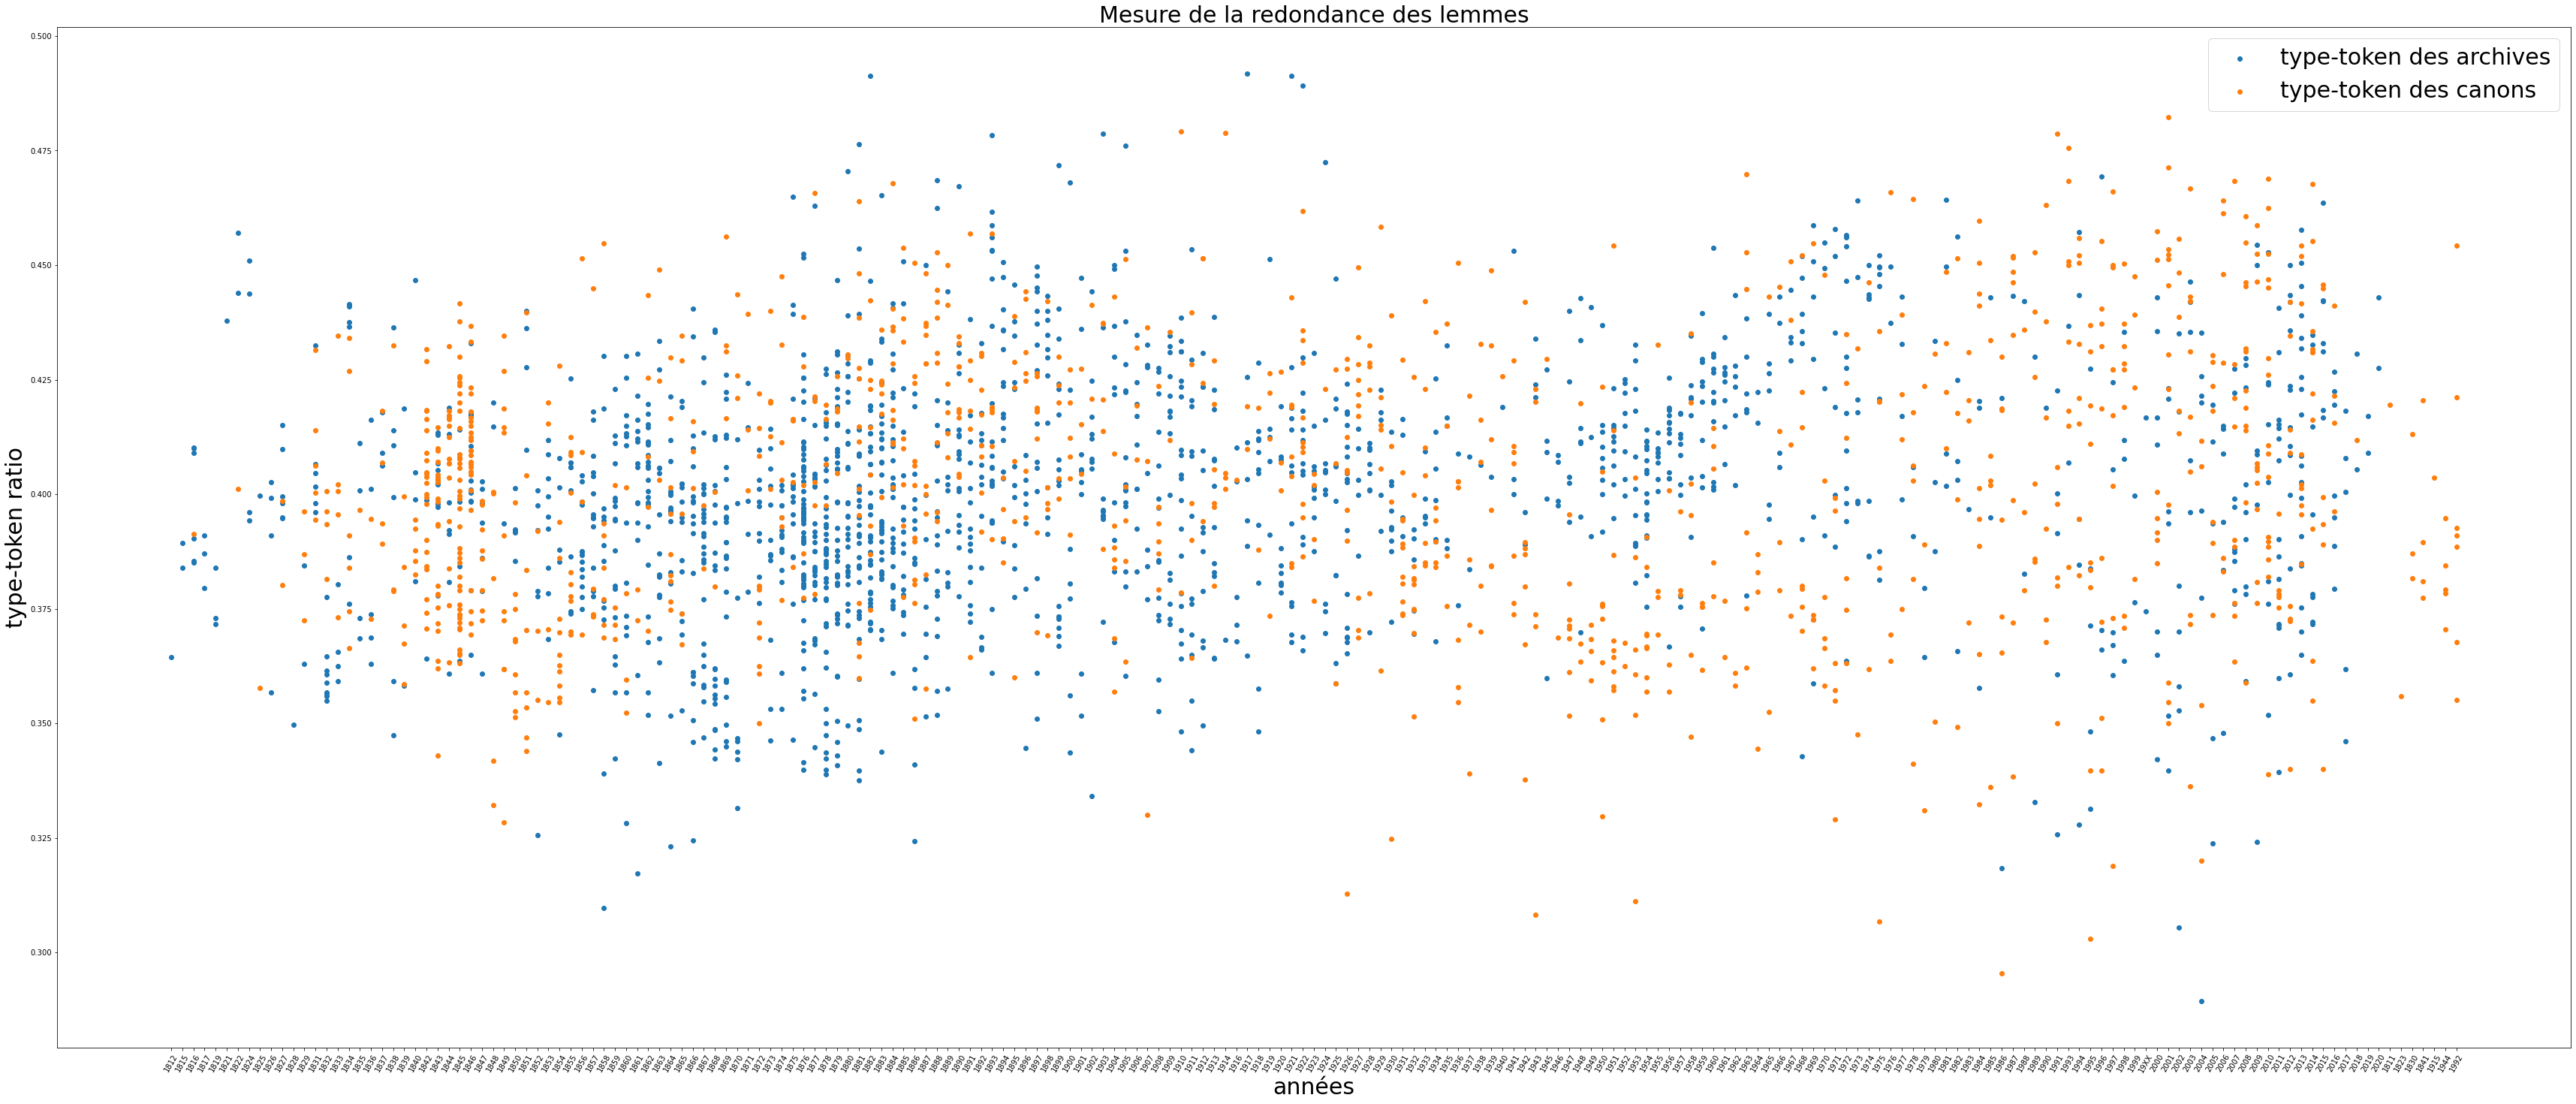

In [43]:
plt.figure(figsize=(60,25))
plt.scatter(annee_archive, type_token_archive_df.mean(), label = 'type-token des archives')
plt.scatter(annee_canon, type_token_canon_df.mean(), label = 'type-token des canons')
plt.ylabel('type-token ratio', fontsize=30)
plt.xlabel('années', fontsize=30)
plt.xticks(rotation=60)

plt.title('Mesure de la redondance des lemmes', fontsize=30)
plt.legend(prop={'size': 30})
plt.show()

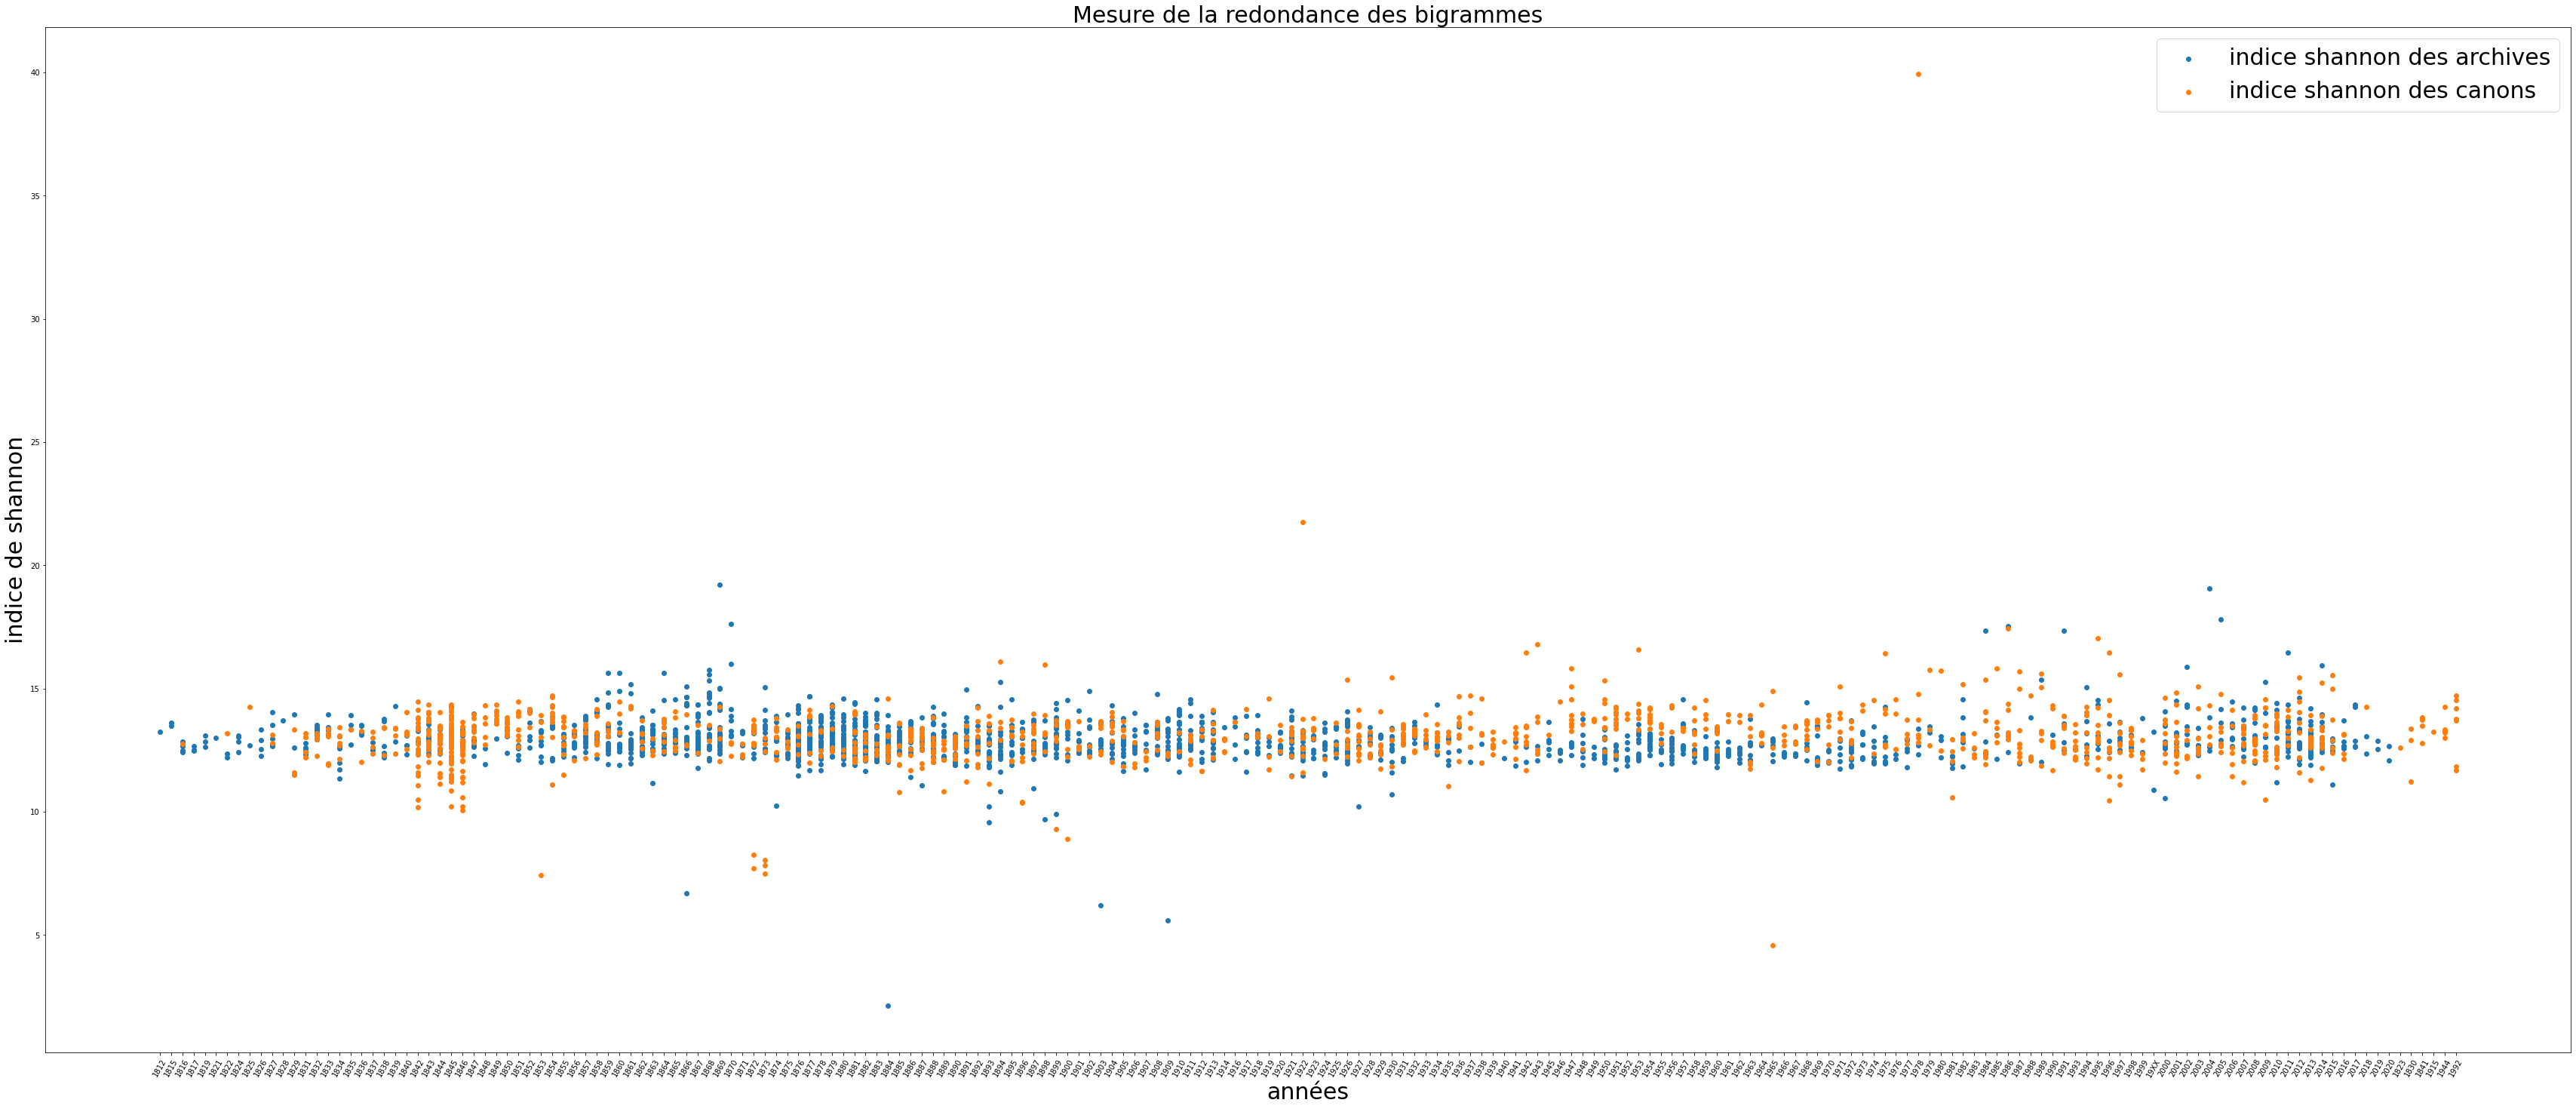

In [23]:
plt.figure(figsize=(60,25))
plt.scatter(annee_archive, shannon_archive_df.mean(), label = 'indice shannon des archives')
plt.scatter(annee_canon, shannon_canon_df.mean(), label = 'indice shannon des canons')
plt.ylabel('indice de shannon', fontsize=30)
plt.xlabel('années', fontsize=30)
plt.xticks(rotation=60)

plt.title('Mesure de la redondance des bigrammes', fontsize=30)
plt.legend(prop={'size': 30})
plt.show()